### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук
#### Кафедра математического моделирования и искусственного интеллекта


## ОТЧЕТ ПО ТЕМЕ № 3, задание № 2

### Дисциплина: Глубокое обучение



##### Студент:  Матюхин Григорий Васильевич
##### Группа:   НПИмд-01-25

Используем CPU здесь, потому что для этой задачи начали возникать проблемы на стороне драйверов.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
)

W0000 00:00:1760041789.052350 1777562 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760041789.052368 1777562 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760041789.052369 1777562 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760041789.052371 1777562 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
2025-10-09 23:29:49.055151: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other o

In [3]:
# utils.py
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


In [4]:
IMAGE_SIZE = 28  # fashion mnist
CHANNELS = 1 # bw
BATCH_SIZE = 128
Z_DIM = 2
LEARNING_RATE = 0.0002
EPOCHS = 10
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

In [5]:
# fashion mnist

import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [6]:
x_train = x_train / 255.0
x_test = x_test / 255.0

## Модель

Здесь тоже используем более маленькую модель

In [7]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

# make the last conv collapse to 1x1
x = layers.Conv2D(1, kernel_size=7, strides=1, padding="valid")(x)  # 7x7 -> 1x1
critic_output = layers.Flatten()(x)  # gives (None, 1)

critic = models.Model(critic_input, critic_output)
critic.summary()

2025-10-09 23:29:50.736120: E external/local_xla/xla/stream_executor/rocm/rocm_platform.cc:50] failed call to hipInit: HIP_ERROR_NoDevice
2025-10-09 23:29:50.736134: I external/local_xla/xla/stream_executor/rocm/rocm_diagnostics.cc:109] retrieving ROCM diagnostic information for host: Mercury
2025-10-09 23:29:50.736136: I external/local_xla/xla/stream_executor/rocm/rocm_diagnostics.cc:116] hostname: Mercury
2025-10-09 23:29:50.736170: I external/local_xla/xla/stream_executor/rocm/rocm_diagnostics.cc:139] librocm reported version is: NOT_FOUND: was unable to find librocm.so DSO loaded into this program
2025-10-09 23:29:50.736172: I external/local_xla/xla/stream_executor/rocm/rocm_diagnostics.cc:143] kernel reported version is: UNIMPLEMENTED: kernel reported driver version not implemented


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1, 1, 1)        │         6,273 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,561 (541.25 KB)

 Trainable params: 138,561 (541.25 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
generator_input = layers.Input(shape=(Z_DIM,))

# Start from latent vector
x = layers.Reshape((1, 1, Z_DIM))(generator_input)

# First Conv2DTranspose: expand to an intermediate feature map
x = layers.Conv2DTranspose(
    128,                 # intermediate number of filters
    kernel_size=7, 
    strides=1, 
    padding="valid", 
    use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

# Second Conv2DTranspose: upsample to 28x28x1 image
x = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=4,
    padding="same",
    use_bias=False
)(x)

# Final activation for output image
generator_output = layers.Activation("tanh")(x)

generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │        12,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 1)      │         2,048 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,104 (59.00 KB)

 Trainable params: 14,848 (58.00 KB)

 Non-trainable params: 256 (1.00 KB)

In [9]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, 
                 critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        # tf.random.uniform?
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps): #1
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, 
                                               training=True)
                real_predictions = self.critic(real_images, 
                                               training=True)

                c_wass_loss = tf.reduce_mean(
                    fake_predictions) - tf.reduce_mean(real_predictions
                ) #2
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                ) #3
                c_loss = c_wass_loss + c_gp * self.gp_weight #4

            c_gradient = tape.gradient(c_loss, 
                                       self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            ) #5

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, 
                                         training=True)
            fake_predictions = self.critic(fake_images, 
                                           training=True)
            g_loss = -tf.reduce_mean(fake_predictions) #6

        gen_gradient = tape.gradient(g_loss, 
                                     self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        ) #7

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [10]:
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [11]:
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [12]:
import os
# Create subdirectories
for path in ["./checkpoint","./logs","./models","./output"]:
    try:
        os.mkdir(path)
        print("Directory '%s' created successfully" % path)
    except OSError as error:
        print("Directory '%s' exists" % path)


Directory './checkpoint' exists
Directory './logs' exists
Directory './models' exists
Directory './output' exists


In [13]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/3-gan-fashion.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/fashion_img_%03d.png" % (epoch),
        )

In [14]:
print(x_train.shape)

(60000, 28, 28)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58s/step - c_gp: 0.7128 - c_loss: 7.0041 - c_wass_loss: -0.1235 - g_loss: 0.0043  
Saved to ./output/fashion_img_000.png


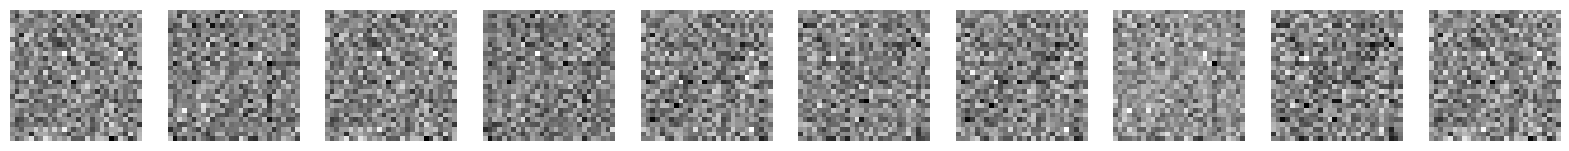

2/2 ━━━━━━━━━━━━━━━━━━━━ 119s 58s/step - c_gp: 0.7039 - c_loss: 6.8660 - c_wass_loss: -0.1732 - g_loss: 0.0031
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60s/step - c_gp: 0.6247 - c_loss: 5.6202 - c_wass_loss: -0.6268 - g_loss: -0.0153 
Saved to ./output/fashion_img_001.png


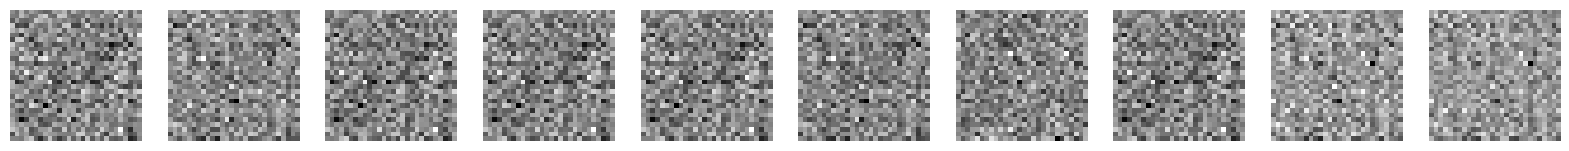

2/2 ━━━━━━━━━━━━━━━━━━━━ 117s 60s/step - c_gp: 0.6100 - c_loss: 5.3800 - c_wass_loss: -0.7198 - g_loss: -0.0208
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57s/step - c_gp: 0.4836 - c_loss: 3.2227 - c_wass_loss: -1.6133 - g_loss: -0.0989 
Saved to ./output/fashion_img_002.png


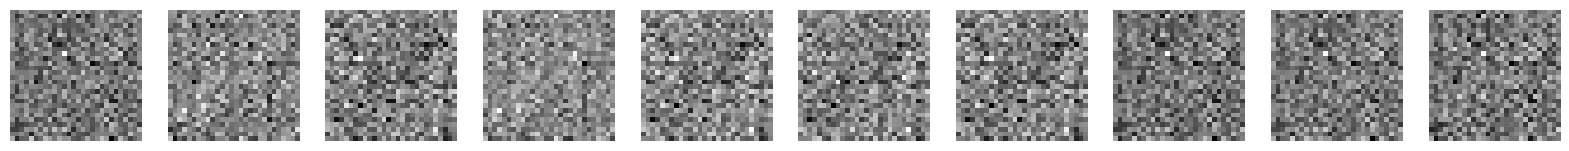

2/2 ━━━━━━━━━━━━━━━━━━━━ 115s 57s/step - c_gp: 0.4604 - c_loss: 2.8089 - c_wass_loss: -1.7952 - g_loss: -0.1204
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62s/step - c_gp: 0.2690 - c_loss: -0.7386 - c_wass_loss: -3.4282 - g_loss: -0.3767 
Saved to ./output/fashion_img_003.png


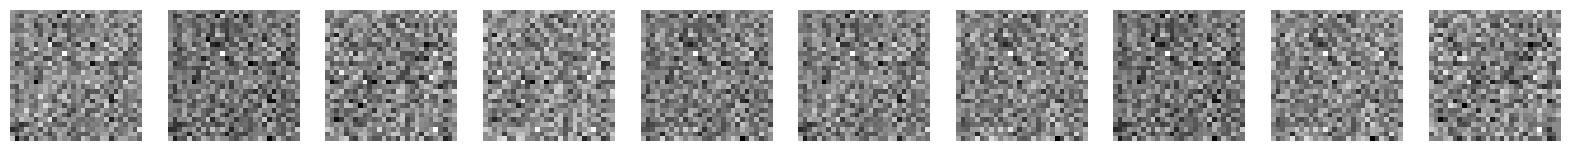

2/2 ━━━━━━━━━━━━━━━━━━━━ 120s 62s/step - c_gp: 0.2379 - c_loss: -1.3539 - c_wass_loss: -3.7325 - g_loss: -0.4383
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61s/step - c_gp: 0.0554 - c_loss: -5.5277 - c_wass_loss: -6.0819 - g_loss: -1.0365  
Saved to ./output/fashion_img_004.png


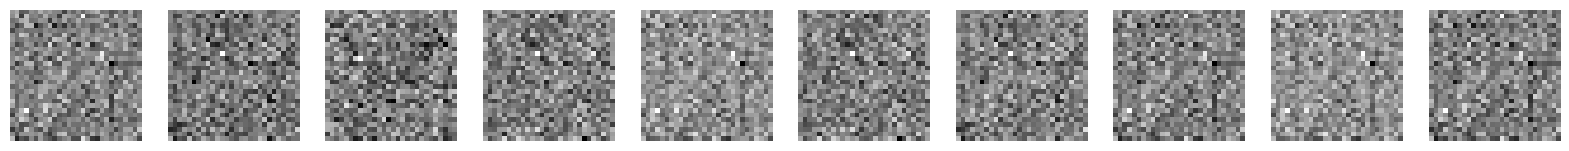

2/2 ━━━━━━━━━━━━━━━━━━━━ 123s 61s/step - c_gp: 0.0418 - c_loss: -6.0322 - c_wass_loss: -6.4506 - g_loss: -1.1547
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57s/step - c_gp: 0.0444 - c_loss: -8.3585 - c_wass_loss: -8.8021 - g_loss: -2.0544  
Saved to ./output/fashion_img_005.png


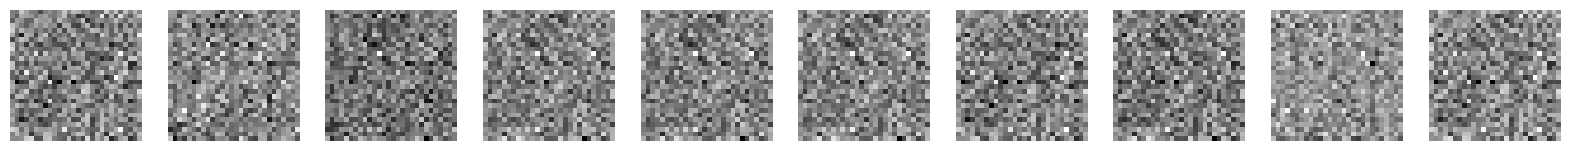

2/2 ━━━━━━━━━━━━━━━━━━━━ 120s 57s/step - c_gp: 0.0585 - c_loss: -8.4962 - c_wass_loss: -9.0817 - g_loss: -2.1820
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59s/step - c_gp: 0.1412 - c_loss: -8.8294 - c_wass_loss: -10.2419 - g_loss: -2.9074  
Saved to ./output/fashion_img_006.png


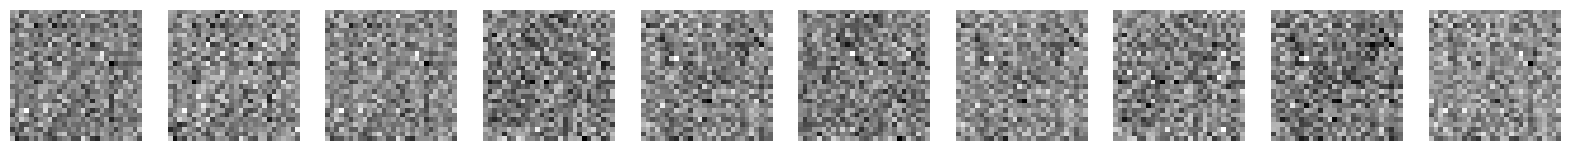

2/2 ━━━━━━━━━━━━━━━━━━━━ 121s 59s/step - c_gp: 0.1459 - c_loss: -8.8220 - c_wass_loss: -10.2809 - g_loss: -2.9804
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58s/step - c_gp: 0.1587 - c_loss: -8.7342 - c_wass_loss: -10.3211 - g_loss: -3.4072  
Saved to ./output/fashion_img_007.png


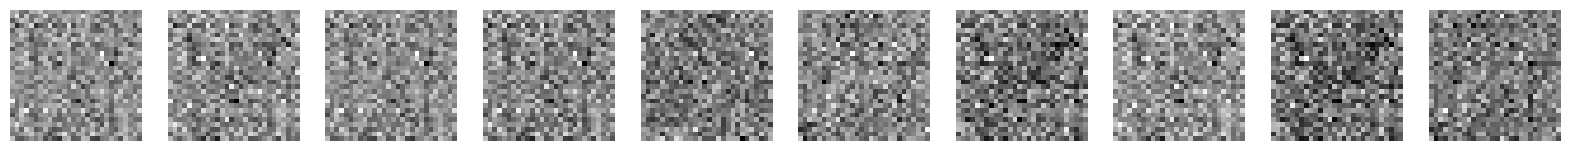

2/2 ━━━━━━━━━━━━━━━━━━━━ 119s 58s/step - c_gp: 0.1592 - c_loss: -8.7331 - c_wass_loss: -10.3255 - g_loss: -3.4595
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57s/step - c_gp: 0.1593 - c_loss: -8.6170 - c_wass_loss: -10.2102 - g_loss: -3.7503 
Saved to ./output/fashion_img_008.png


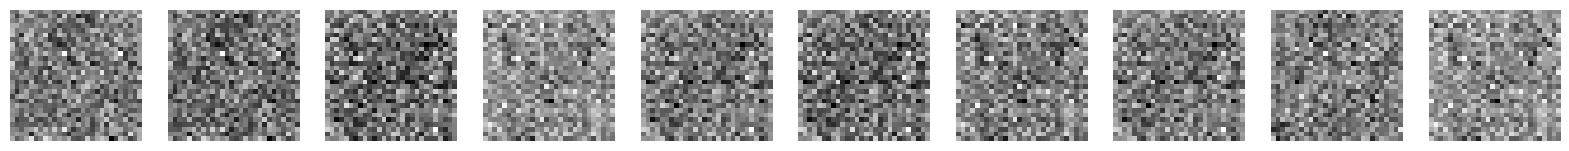

2/2 ━━━━━━━━━━━━━━━━━━━━ 114s 57s/step - c_gp: 0.1591 - c_loss: -8.5816 - c_wass_loss: -10.1727 - g_loss: -3.7822
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57s/step - c_gp: 0.1553 - c_loss: -8.4169 - c_wass_loss: -9.9697 - g_loss: -3.9828  
Saved to ./output/fashion_img_009.png


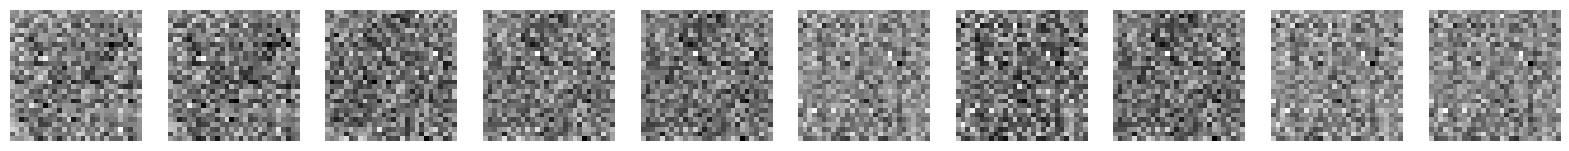

2/2 ━━━━━━━━━━━━━━━━━━━━ 115s 57s/step - c_gp: 0.1543 - c_loss: -8.3808 - c_wass_loss: -9.9239 - g_loss: -4.0093


In [15]:
import numpy as np

wgangp.fit(
    np.expand_dims(x_train, axis=-1),
    epochs=EPOCHS,
    steps_per_epoch=2,
    callbacks=[
    #    model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
    verbose=1,
)

## Образы случайных точек латентного простанства

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


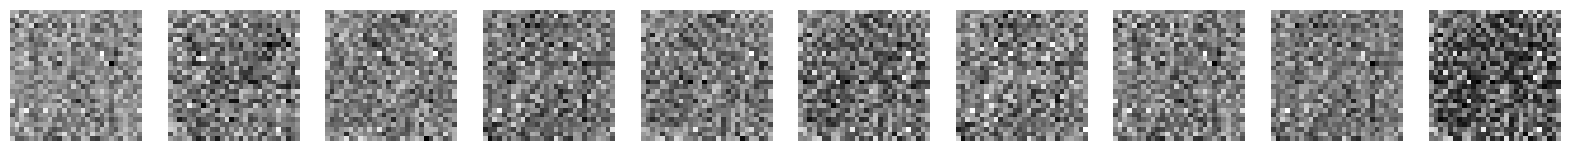

In [17]:
import numpy as np

z_sample = np.random.normal(size=(10, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
display(imgs)